In [1]:
import pandas as pd

from functions import (
    train_val_test_split,
    test_variables,
    get_best_treshold,
    print_metrics,
    plot_roc_curve,
    plot_precision_recall_curve
)

In [2]:
df = pd.read_csv('../../data/box_builder_dataset/feature_frame.csv')

Let's remember what whe had in the previous task. This is the dataframe information and a sample of the data:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [4]:
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


## Preparing the dataset

To get the lenght of the orders, we have to get the products with `outcome` = 1, which means that they were ordered.

In [5]:
ordered = df[df['outcome'] == 1]

We need to get the orders with at least 5 products

First we need to group the data by order_id and count the number of products in each order. Then we filter the orders with at least 5 products.

In [6]:
orders_len = ordered.groupby('order_id')['variant_id'].count()
orders_len.describe()

count    3427.000000
mean        9.697111
std         6.789204
min         1.000000
25%         5.000000
50%         9.000000
75%        13.000000
max        78.000000
Name: variant_id, dtype: float64

In [7]:
orders_over_eq_5 = orders_len[orders_len >= 5].index

In [8]:
df = df[df['order_id'].isin(orders_over_eq_5)]

In [9]:
df.shape

(2163953, 27)

In [10]:
df['variant_id'].nunique()

976

Now we have reduced the size of the dataset getting only the orders with at least 5 products. We can now start thinking about the next steps.

## Model building

The objective: *build a linear model that, given a user and a product, predicts if the user would purchase it if they were buying with us at that point in time.* 


The model may be based on logistic regression. 
It should predict if a user would buy a product or not, which is a binary outcome.
On the dataset we have a variable that contains this value, `outcome`, so we can use it as the target variable.

A first approach to the model could be to use the following features:
- times_ordered
- abandoned_before
- active_snoozed
- set_as_regular
- global_popularity
- days_to_purchase_variant_id_norm  * ordered_before = ((days_since_last_purchase_variant_id - avg_days_to_buy_variant_id) / std_days_to_buy_variant_id)  * ordered_before
- days_to_purchase_product_type_norm = (days_since_last_purchase_product_type - avg_days_to_buy_product_type) / std_days_to_buy_product_type

We can start with these features and then add or remove some of them to see if the model improves.


The model would look like this:

$$
log(\frac{p}{1-p}) = \beta_0 + \beta_1 \cdot times\_ordered + \beta_2 \cdot abandoned\_before + \\
+ \beta_3 \cdot active\_snoozed + \beta_4 \cdot set\_as\_regular + \beta_5 \cdot global\_popularity + \\
+ \beta_6 \cdot days\_to\_purchase\_variant\_id\_norm \cdot ordered\_before + \\
+ \beta_7 \cdot days\_to\_purchase\_product\_type\_norm
$$

In [11]:
features = ['times_ordered', 'abandoned_before', 'active_snoozed', 'set_as_regular', 'global_popularity', 'days_to_purchase_variant_id_norm', 'days_to_purchase_variant_id_if_ordered_before', 'days_to_purchase_product_type_norm']

Now we have to create the variables that we are going to use in the model if we don't have them already.

One approach to create the dataframe is get only one row for each user-product pair, and then add the features to the dataframe. This way we can use the user-product pair as the index of the dataframe and the outcome as the target variable.

In [12]:
df_sorted = df.sort_values(by=['user_id', 'order_date'], ascending=[True, False])

In [13]:
last_variant_df = df_sorted.groupby(['user_id', 'variant_id']).first().reset_index()

Now we have a dataframe where we have a row for each user-product pair using the last time the user bought the product. We can now add the features to the dataframe.

Let's start by adding the `times_ordered` feature. We can use the `groupby` method to get the number of times the user bought the product.

In [14]:
times_ordered = df.groupby(['user_id', 'variant_id'])['outcome'].sum().reset_index().rename(columns={'outcome': 'times_ordered'})

In [15]:
last_variant_df = last_variant_df.merge(times_ordered, on=['user_id', 'variant_id'], how='left')

The next features are `days_to_purchase_variant_id_norm` and `days_to_purchase_product_type_norm`. We can use the formula mentioned before to get them.

In [16]:
last_variant_df['days_to_purchase_variant_id_norm'] = (last_variant_df['avg_days_to_buy_variant_id'] - last_variant_df['days_since_purchase_variant_id']) / last_variant_df['std_days_to_buy_variant_id']

last_variant_df['days_to_purchase_variant_id_if_ordered_before'] = last_variant_df['days_to_purchase_variant_id_norm'] * last_variant_df['ordered_before']

In [17]:
last_variant_df['days_to_purchase_product_type_norm'] = (last_variant_df['avg_days_to_buy_product_type'] - last_variant_df['days_since_purchase_product_type']) / last_variant_df['std_days_to_buy_product_type']

Let's create the final dataframe with the features and the target variable. Then we can build the model and evaluate it.

In [18]:
final_df = last_variant_df[['user_id', 'variant_id', 'outcome', *features]].copy()

First we set an alias for the input data and the target variable.

In [19]:
X = last_variant_df[features].copy()
y = last_variant_df['outcome'].copy()

It's time to split the data into training, validation and test sets. We can use the `train_test_split` method from the `sklearn` library to do this.

In [20]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)

Now we can build the model using the training set and evaluate it using the validation set.

In [21]:
result_statmodels = test_variables(X_train, y_train)

Optimization terminated successfully.
         Current function value: 0.018003
         Iterations 11


In [22]:
print(result_statmodels.summary())

                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:               641048
Model:                          Logit   Df Residuals:                   641039
Method:                           MLE   Df Model:                            8
Date:                Sat, 10 Feb 2024   Pseudo R-squ.:                  0.7508
Time:                        18:03:23   Log-Likelihood:                -11541.
converged:                       True   LL-Null:                       -46301.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -7.2226      0.044   -162.326      0.000      -7.310      -7.135
times_ordered             

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
model = LogisticRegression()

In [25]:
model.fit(X_train, y_train)

LogisticRegression()

In [26]:
y_val_pred_prob = model.predict_proba(X_val)[:, 1]

best_threshold = get_best_treshold(y_val, y_val_pred_prob)

In [27]:
y_val_pred = [1 if p > best_threshold else 0 for p in y_val_pred_prob]

In [28]:
print_metrics(y_val, y_val_pred)

Accuracy: 0.9958651063752343
Confusion Matrix:
 [[270117    778]
 [   358   3482]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    270895
         1.0       0.82      0.91      0.86      3840

    accuracy                           1.00    274735
   macro avg       0.91      0.95      0.93    274735
weighted avg       1.00      1.00      1.00    274735



Once we have tried the model with the validation set, let's make another model using other features and compare the results.

We can let the model metrics speak for themselves to decide which features are the best to use in the model. 

We can use the p-values to check if the features are significant or not.
If the p-value is greater than 0.05 (for example), we can remove the feature from the model, as it doesn't have a significant impact on the target variable.

Let's start with all features but the ones that aren't encoded as binary variables or that are not float numbers.

In [29]:
not_in_model = ['user_id', 'variant_id', 'order_id','product_type','created_at', 'order_date', 'outcome', 'vendor']
not_in_model.extend([x for x in df.columns if 'count_' in x or 'baby' in x])
X_2 = last_variant_df.drop(columns=not_in_model).copy()

In [30]:
X_train2, X_val2, X_test2, y_train2, y_val2, y_test2 = train_val_test_split(X_2, y)

In [31]:
p_values = pd.Series([1])
bad_p_values = []
while any(p > 0.05 for p in p_values):
    result_statmodels_auto = test_variables(X_train2.drop(columns=bad_p_values), y_train2)
    p_values = result_statmodels_auto.pvalues
    bad_p_values.append(p_values.idxmax())

Optimization terminated successfully.
         Current function value: 0.010783
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010783
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010783
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010784
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010785
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010786
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010786
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010787
         Iterations 11


In [32]:
print(result_statmodels_auto.summary())

                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:               641048
Model:                          Logit   Df Residuals:                   641037
Method:                           MLE   Df Model:                           10
Date:                Sat, 10 Feb 2024   Pseudo R-squ.:                  0.8505
Time:                        18:03:43   Log-Likelihood:                -6915.3
converged:                       True   LL-Null:                       -46259.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -5.0488      0.127    -39.659      0.000      -5.298      -4.799
user_order_seq                      -0.8111      0.020    -41.242

In [33]:
good_features = p_values.index[p_values < 0.05].tolist()
good_features = [f for f in good_features if f != 'const']

print(good_features)
print(len(good_features))

['user_order_seq', 'ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular', 'global_popularity', 'days_since_purchase_variant_id', 'avg_days_to_buy_variant_id', 'days_since_purchase_product_type', 'times_ordered']
10


In [34]:
X_3 = X_2[good_features].copy()

In [35]:
X_train3, X_val3, X_test3, y_train3, y_val3, y_test3 = train_val_test_split(X_3, y)

In [36]:
model_auto = LogisticRegression()

In [37]:
model_auto.fit(X_train3, y_train3)

LogisticRegression()

In [38]:
y_val_pred_auto = model_auto.predict(X_val3)
y_val_pred_prob_auto = model_auto.predict_proba(X_val3)[:, 1]

In [39]:
print_metrics(y_val3, y_val_pred_auto)

Accuracy: 0.9973392541904017
Confusion Matrix:
 [[270776    155]
 [   576   3228]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    270931
         1.0       0.95      0.85      0.90      3804

    accuracy                           1.00    274735
   macro avg       0.98      0.92      0.95    274735
weighted avg       1.00      1.00      1.00    274735



In [40]:
best_threshold_auto = get_best_treshold(y_val3, y_val_pred_prob_auto)
best_threshold_auto

0.34056812111286083

In [41]:
y_val_pred_auto = [1 if p > best_threshold_auto else 0 for p in y_val_pred_prob_auto]

In [42]:
print_metrics(y_val3, y_val_pred_auto)

Accuracy: 0.9983511383697017
Confusion Matrix:
 [[270759    172]
 [   281   3523]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    270931
         1.0       0.95      0.93      0.94      3804

    accuracy                           1.00    274735
   macro avg       0.98      0.96      0.97    274735
weighted avg       1.00      1.00      1.00    274735



As seen in the metrics shown, the second model is performing better than the first one.


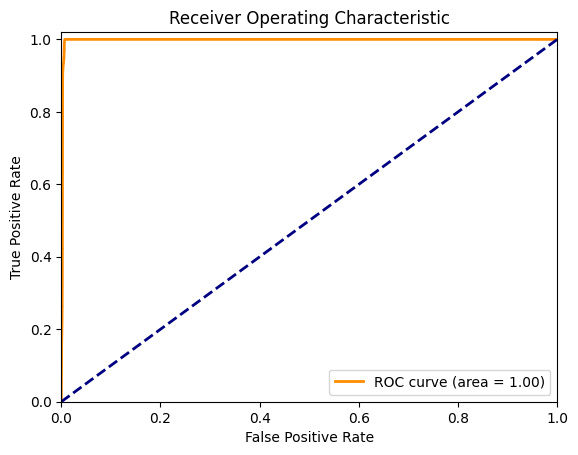

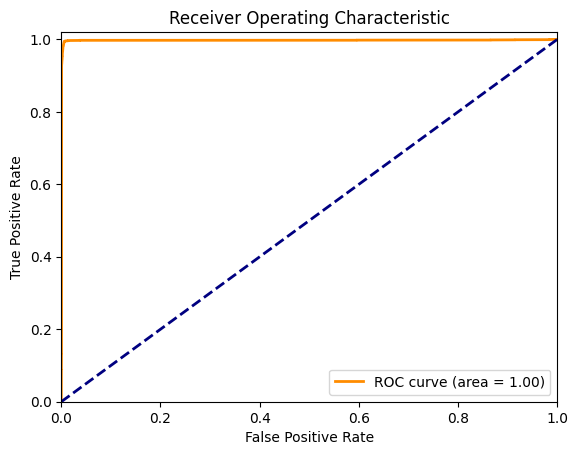

In [43]:
plot_roc_curve(y_val, y_val_pred_prob)
plot_roc_curve(y_val3, y_val_pred_prob_auto)

The roc curve shows that the model is performing perfectly, as the AUC is 1.0

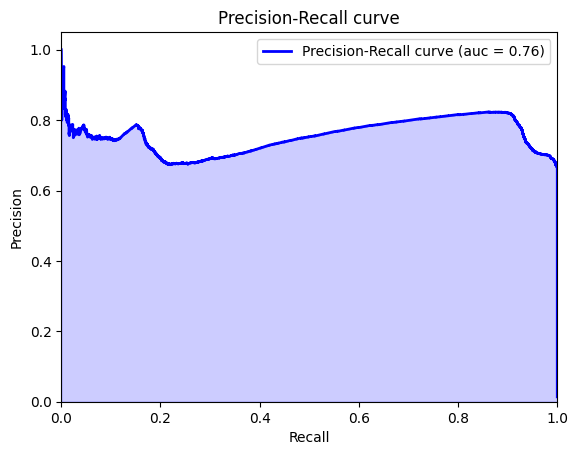

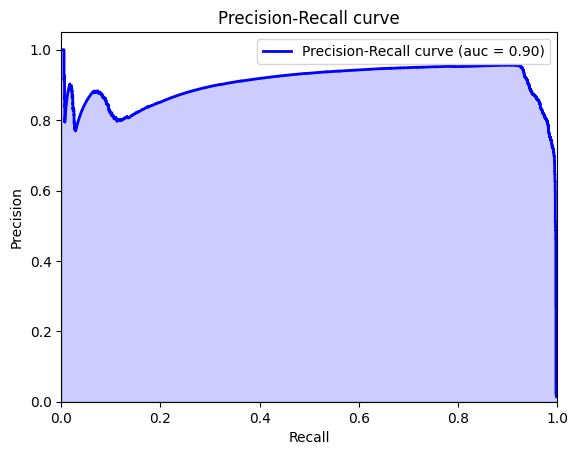

In [44]:
plot_precision_recall_curve(y_val, y_val_pred_prob)
plot_precision_recall_curve(y_val3, y_val_pred_prob_auto)

If we take a look at the precision-recall curve, we can see that the second model is performing better than the first one, as the AUC is greater.

### Test prediction

Now it's time to evaluate the model using the test set. We are going to use the second model to make the predictions.

In [45]:
y_test_prob_pred_auto = model_auto.predict_proba(X_test3)[:, 1]

In [46]:
y_test_pred_auto = [1 if prob > best_threshold_auto else 0 for prob in y_test_prob_pred_auto]

We can use the same metrics to evaluate the model using the test set.

In [47]:
print_metrics(y_test3, y_test_pred_auto)

Accuracy: 0.998275066946257
Confusion Matrix:
 [[386880    264]
 [   413   4922]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    387144
         1.0       0.95      0.92      0.94      5335

    accuracy                           1.00    392479
   macro avg       0.97      0.96      0.97    392479
weighted avg       1.00      1.00      1.00    392479



It seems that the model is performing well in the test set too.

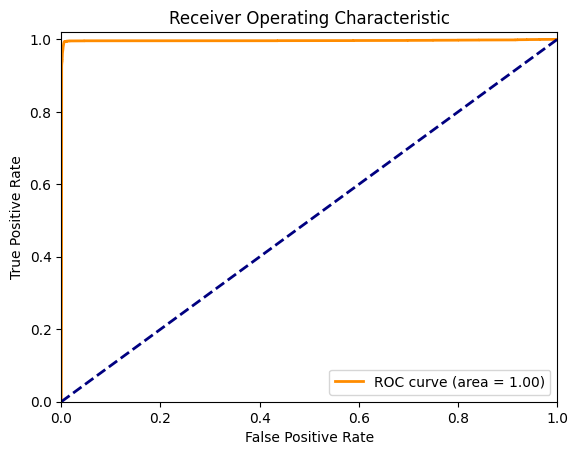

In [48]:
plot_roc_curve(y_test3, y_test_prob_pred_auto)

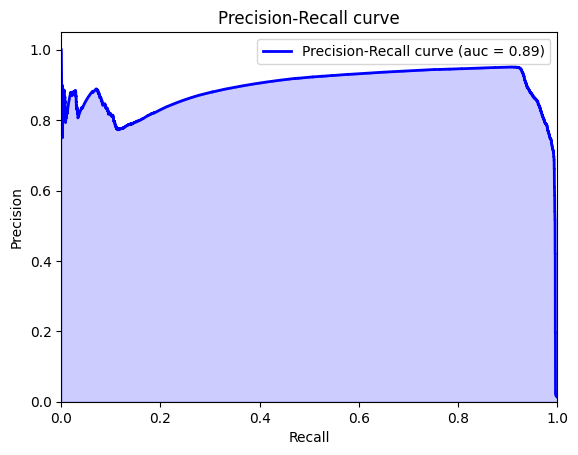

In [49]:
plot_precision_recall_curve(y_test3, y_test_prob_pred_auto)

## Conclusion

As a conclusion, we can say that the model is performing well, as it is predicting the buyers (`outcome` = 1) with more than 90% accuracy. 

We have used the features that the iterative algorithm has found before and we have evaluated the model using the training, validation and test sets. 

The model is predicting the outcome correctly in 99% of the cases.

We can say that the model is performing well and we can use it to predict if a user would buy a product or not.